Initial shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Columns: ['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'sub_category', 'product_name', 'sales', 'quantity', 'discount', 'profit']
After dedupe: (9994, 21)
row_id           0
order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
customer_name    0
segment          0
country          0
city             0
state            0
postal_code      0
region           0
product_id       0
category         0
sub_category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
dtype: int64
After dropping rows with missing critical fields: (9994, 21)
Total Sales: 2,297,200.86
Total Profit: 286,397.02
Average Discount: 0.16


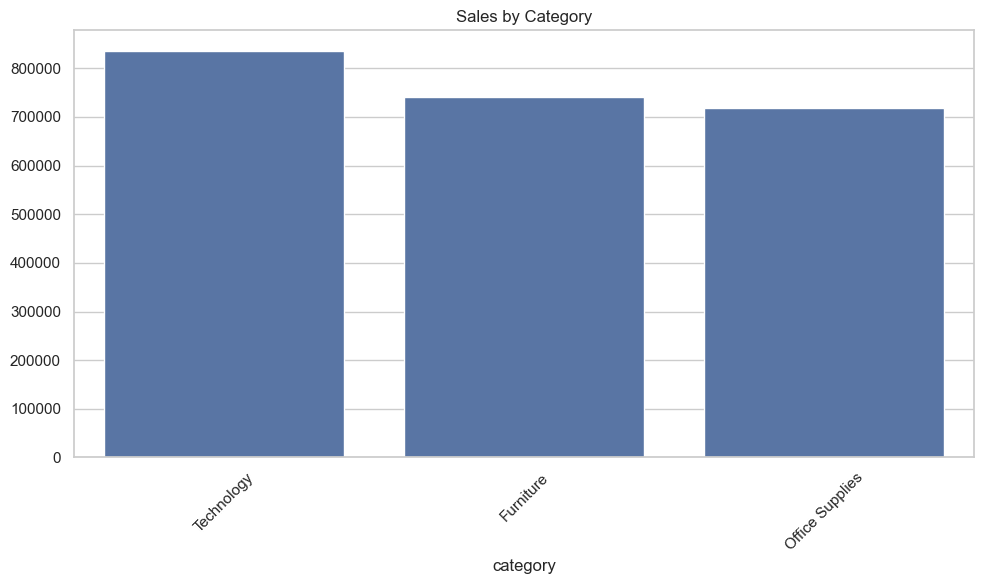

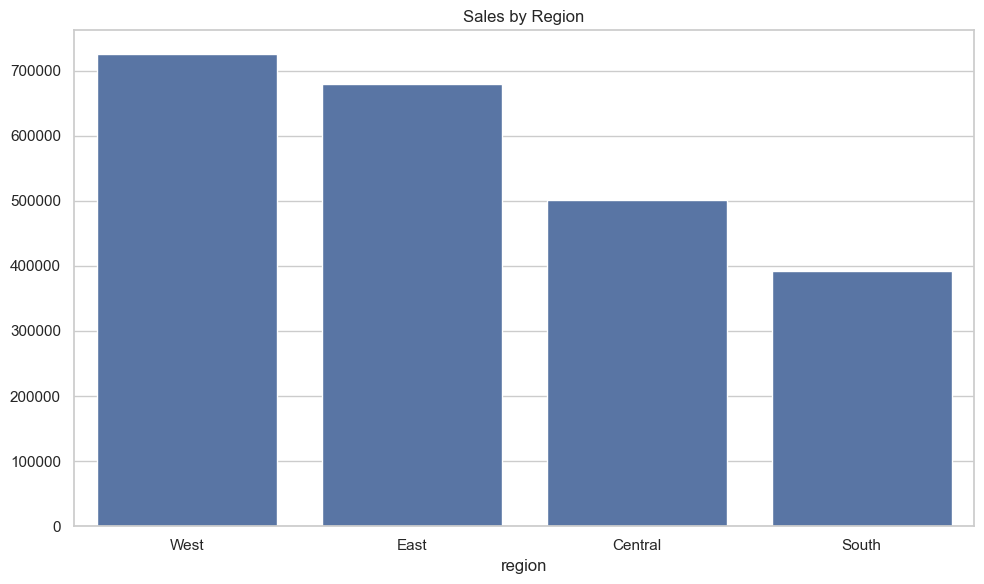

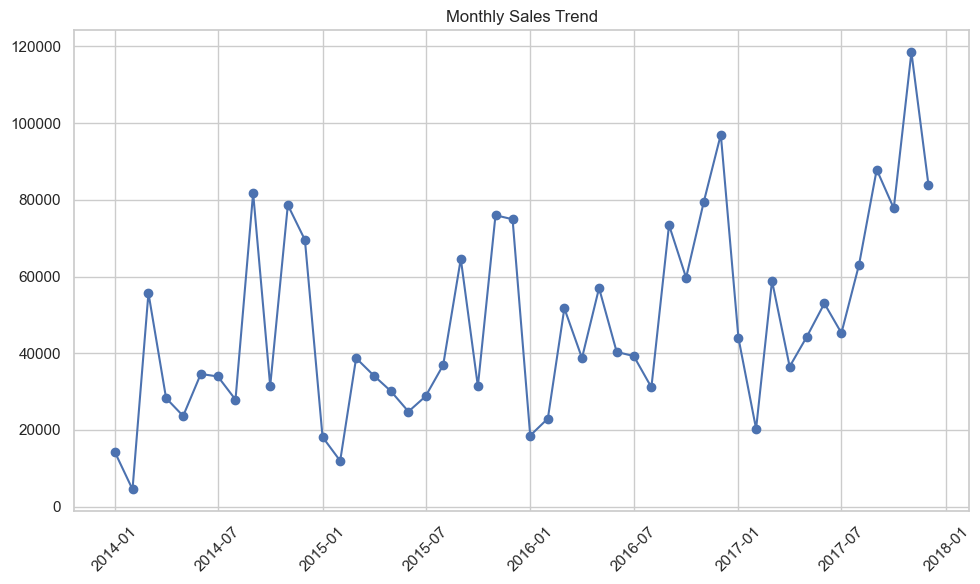

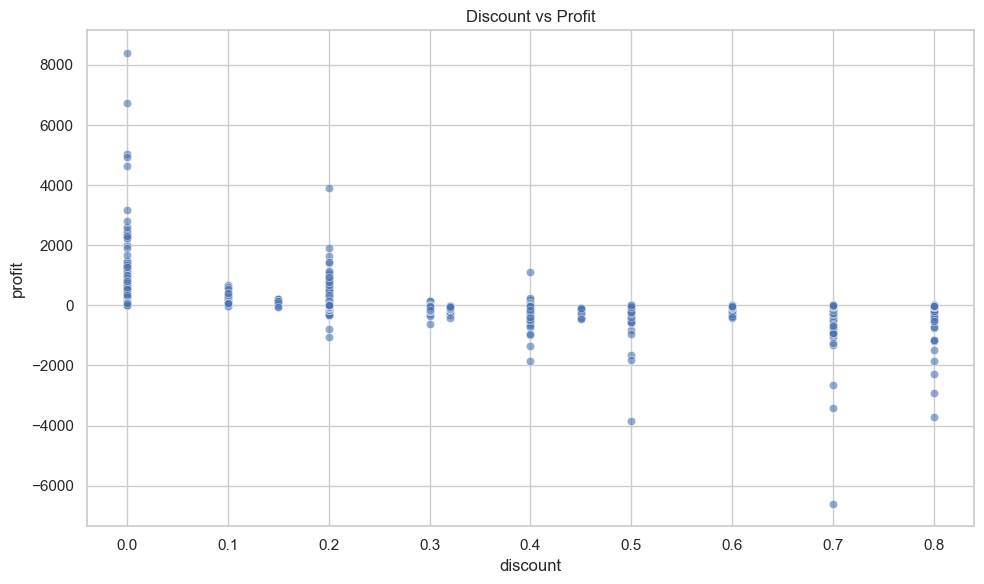

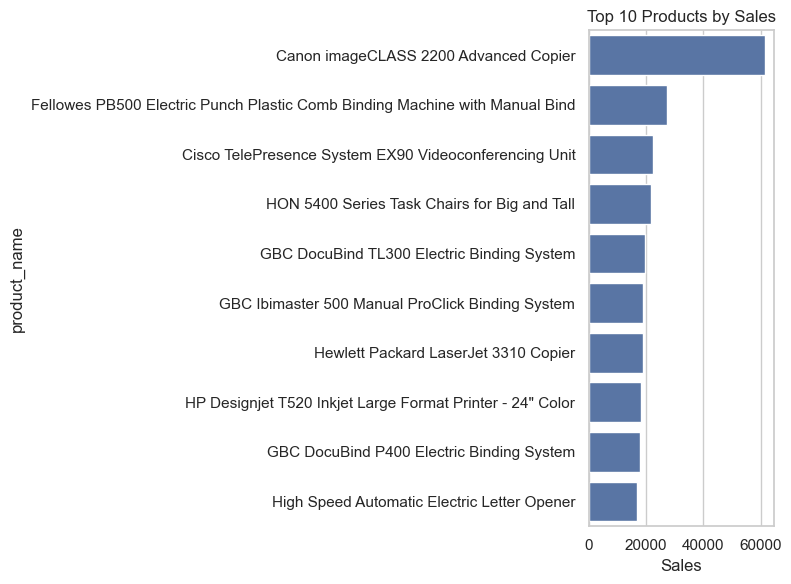

Saved cleaned CSV to: data/cleaned_sales.csv


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# ===== Paths =====
raw_csv = "Superstore.csv"                       # your uploaded file
clean_csv = "data/cleaned_sales.csv"
os.makedirs("data", exist_ok=True)
os.makedirs("output_plots", exist_ok=True)

# ===== 1) Load CSV with encoding fallback =====
try:
    data = pd.read_csv(raw_csv, encoding='utf-8', low_memory=False)
except UnicodeDecodeError:
    data = pd.read_csv(raw_csv, encoding='latin1', low_memory=False)

print("Initial shape:", data.shape)
display(data.head())

# ===== 2) Normalize column names =====
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
print("Columns:", data.columns.tolist())

# ===== 3) Remove duplicates =====
data = data.drop_duplicates()
print("After dedupe:", data.shape)

# ===== 4) Missing value overview =====
print(data.isnull().sum())

# ===== 5) Drop rows with missing critical fields =====
critical_cols = [c for c in ['sales','profit','quantity','order_date'] if c in data.columns]
if critical_cols:
    data = data.dropna(subset=critical_cols)
    print("After dropping rows with missing critical fields:", data.shape)

# ===== 6) Convert date columns =====
for date_col in ['order_date', 'ship_date']:
    if date_col in data.columns:
        data[date_col] = pd.to_datetime(data[date_col], errors='coerce')

# ===== 7) Convert numeric columns =====
for num_col in ['sales','profit','discount','quantity']:
    if num_col in data.columns:
        data[num_col] = pd.to_numeric(data[num_col], errors='coerce')

# Drop rows still having NaN in sales or profit
data = data[~data['sales'].isnull()]
data = data[~data['profit'].isnull()]

# ===== 8) Trim string columns =====
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype(str).str.strip()

# ===== 9) Feature engineering =====
if 'order_date' in data.columns:
    data['year'] = data['order_date'].dt.year
    data['month_str'] = data['order_date'].dt.strftime('%Y-%m')
    data['month'] = data['order_date'].dt.to_period('M')

# Profit margin
data['profit_margin'] = data['profit'] / data['sales']
data['profit_margin_pct'] = data['profit_margin'] * 100

# ===== 10) Quick KPIs =====
total_sales = data['sales'].sum()
total_profit = data['profit'].sum()
avg_discount = data['discount'].mean() if 'discount' in data.columns else np.nan

print(f"Total Sales: {total_sales:,.2f}")
print(f"Total Profit: {total_profit:,.2f}")
print(f"Average Discount: {avg_discount:.2f}")

# ===== 11) EDA Visualizations =====

# Sales by category
if 'category' in data.columns:
    cat_sales = data.groupby('category')['sales'].sum().sort_values(ascending=False)
    plt.figure()
    sns.barplot(x=cat_sales.index, y=cat_sales.values)
    plt.xticks(rotation=45)
    plt.title("Sales by Category")
    plt.tight_layout()
    plt.savefig("output_plots/sales_by_category.png")
    plt.show()

# Sales by region
if 'region' in data.columns:
    reg_sales = data.groupby('region')['sales'].sum().sort_values(ascending=False)
    plt.figure()
    sns.barplot(x=reg_sales.index, y=reg_sales.values)
    plt.title("Sales by Region")
    plt.tight_layout()
    plt.savefig("output_plots/sales_by_region.png")
    plt.show()

# Monthly sales trend
if 'month_str' in data.columns:
    monthly_sales = data.groupby('month_str')['sales'].sum().reset_index()
    monthly_sales['month_str'] = pd.to_datetime(monthly_sales['month_str'])
    monthly_sales = monthly_sales.sort_values('month_str')
    plt.figure()
    plt.plot(monthly_sales['month_str'], monthly_sales['sales'], marker='o')
    plt.title("Monthly Sales Trend")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("output_plots/monthly_sales_trend.png")
    plt.show()

# Discount vs Profit scatter
if 'discount' in data.columns:
    plt.figure()
    sns.scatterplot(x='discount', y='profit', data=data, alpha=0.6)
    plt.title("Discount vs Profit")
    plt.tight_layout()
    plt.savefig("output_plots/discount_vs_profit.png")
    plt.show()

# Top 10 products by sales
if 'product_name' in data.columns:
    top10_products = data.groupby('product_name')['sales'].sum().nlargest(10)
    plt.figure(figsize=(8,6))
    sns.barplot(y=top10_products.index, x=top10_products.values)
    plt.title("Top 10 Products by Sales")
    plt.xlabel("Sales")
    plt.tight_layout()
    plt.savefig("output_plots/top10_products.png")
    plt.show()

# ===== 12) Save cleaned CSV =====
data.to_csv(clean_csv, index=False, encoding='utf-8')
print("Saved cleaned CSV to:", clean_csv)


In [9]:
data.to_csv("data/cleaned_sales.csv", index=False, encoding='utf-8')
from IPython.display import HTML

file_path = "data/cleaned_sales.csv"
HTML(f'<a href="{file_path}" download="cleaned_sales.csv">Click here to download cleaned_sales.csv</a>')

In [10]:
!pip install mysql-connector-python


   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ------ --------------------------------- 2.6/16.4 MB 25.8 MB/s eta 0:00:01
   --------- ------------------------------ 3.9/16.4 MB 11.8 MB/s eta 0:00:02
   ------------------- -------------------- 7.9/16.4 MB 15.5 MB/s eta 0:00:01
   ----------------------- ---------------- 9.4/16.4 MB 12.8 MB/s eta 0:00:01
   ----------------------------- ---------- 12.1/16.4 MB 12.8 MB/s eta 0:00:01
   ------------------------------------ --- 14.9/16.4 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 12.8 MB/s eta 0:00:00


In [11]:
import mysql.connector
print("MySQL connector is installed!")


MySQL connector is installed!


In [15]:
# ===== Section: Upload Cleaned CSV to MySQL =====
import mysql.connector
from mysql.connector import Error

# List of columns in MySQL table (must match cleaned CSV)
mysql_cols = [
    'order_id','order_date','ship_date','ship_mode','customer_name','segment',
    'country','city','state','region','product_id','category','sub_category',
    'product_name','sales','quantity','discount','profit','profit_margin',
    'profit_margin_pct','month_str','year','month'
]

try:
    # Connect to MySQL
    conn = mysql.connector.connect(
        host="localhost",
        user="root",          # Replace with your MySQL username
        password="Oankar2001",  # Replace with your MySQL password
        database="sales_db"    # Make sure sales_db exists
    )

    if conn.is_connected():
        print("✅ Connected to MySQL")

    cur = conn.cursor()

    # Keep only columns present in MySQL table
    data_mysql = data[[c for c in mysql_cols if c in data.columns]]

    # Replace NaN with None
    data_mysql = data_mysql.where(pd.notnull(data_mysql), None)

    # Convert dates to string format YYYY-MM-DD
    for date_col in ['order_date', 'ship_date']:
        if date_col in data_mysql.columns:
            data_mysql[date_col] = pd.to_datetime(data_mysql[date_col], errors='coerce').dt.strftime('%Y-%m-%d')

    # Convert Period column to string
    if 'month' in data_mysql.columns:
        data_mysql['month'] = data_mysql['month'].astype(str)

    # Prepare INSERT statement
    cols = data_mysql.columns.tolist()
    placeholders = ", ".join(["%s"] * len(cols))
    insert_sql = f"INSERT INTO sales_table ({', '.join(cols)}) VALUES ({placeholders})"

    # Prepare rows for insertion
    rows = [tuple(x) for x in data_mysql.to_numpy()]

    # Insert in batches
    batch_size = 1000
    for i in range(0, len(rows), batch_size):
        batch = rows[i:i+batch_size]
        cur.executemany(insert_sql, batch)
        conn.commit()
        print(f"Inserted rows {i} to {i + len(batch)}")

except Error as e:
    print("❌ Error:", e)

finally:
    if cur:
        cur.close()
    if conn:
        conn.close()
        print("✅ MySQL connection closed")


✅ Connected to MySQL
Inserted rows 0 to 1000
Inserted rows 1000 to 2000
Inserted rows 2000 to 3000
Inserted rows 3000 to 4000
Inserted rows 4000 to 5000
Inserted rows 5000 to 6000
Inserted rows 6000 to 7000
Inserted rows 7000 to 8000
Inserted rows 8000 to 9000
Inserted rows 9000 to 9994
✅ MySQL connection closed
